Для решения поставленной задачи можно использовать несколько методов компьютерного зрения.
Первый подход заключается в классическом решении на основе feature matching. Идея заключается в том, что с использованием методов SIFT, ORB или SURF выделяются ключевые точки на изображении логотипа и входном изображении. А далее происходит сопоставление признаков с использованием, например, BFMatcher. Далее с помощью RANSAC можно удалить выбросы и проверить геометрические соотвествия. Есть свои преимущества и недостатки в таком подходе. Преимущества этого подхода заключаются в том, что он не требует обучения модели и основывается исключительно на сравнении ключевых точек. Однако есть и недостатки — метод плохо работает при изменениях в цвете, а также дает низкую точность при обработке изображений с плохим качеством.

Второй подход это использование CNN на базе, например, ResNet. Необходимо собрать датасет, обучить модель на классификации логотипов.  Для каждого нового логотипа будет построен эмбеддинг и они в дальнейшем будут сравниваться с уже существующими эмбеддингами с использованием cosine similarity. Плюсы такого подхода лучше справляется с изменениями цвета. Если говорить про минусы, то требуется мощность и зависит от качества обучающей выборки.

Также можно использовать трансформер, например, ViT. Но для данного способа требуется еще больше мощности, хотя поиск логотипов будет без явного списка классов.

Рассмотрим первый способ с выделением фичей

In [61]:
import cv2
import matplotlib.pyplot as plt

сделаем преобработку изображений

In [62]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize =(8,8))
    return clahe.apply(image)

функция для извлечения ключевых фичей с использованием SIFT (также пробовала с ORB - результат был примерно таким же)

In [63]:
def extract_features_sift(image_path):
    sift = cv2.SIFT_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, desciptiors = sift.detectAndCompute(image, None)
    return image, keypoints, desciptiors

Функция для сравнения для двух изображений

In [64]:
def match_logos_sift(first_image_path, logo_image_path):
    img1, kp1, desc1 = extract_features_sift(first_image_path)
    img2, kp2, desc2 = extract_features_sift(logo_image_path)
    if desc1 is None or desc2 is None:
        print('No description found')
        return img1, img2, [], kp1, kp2
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    return img1, img2, matches, kp1, kp2



Визуализация результатов

In [65]:
def visualize_matches(first_image_path, logo_image_path):
    img1, img2, matches, kp1, kp2 = match_logos_sift(first_image_path, logo_image_path)
    img1_kp = cv2.drawKeypoints(img1, kp1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kp = cv2.drawKeypoints(img2, kp2, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.imshow(img1_kp, cmap = 'gray')
    plt.title('First Image Keypoints')
    plt.subplot(1, 3, 2)
    plt.imshow(img2_kp, cmap = 'gray')
    plt.title('Logo Image Keypoints')
    plt.subplot(1, 3, 3)
    plt.imshow(match_img, cmap = 'gray')
    plt.title('Matches')

    plt.show()
    



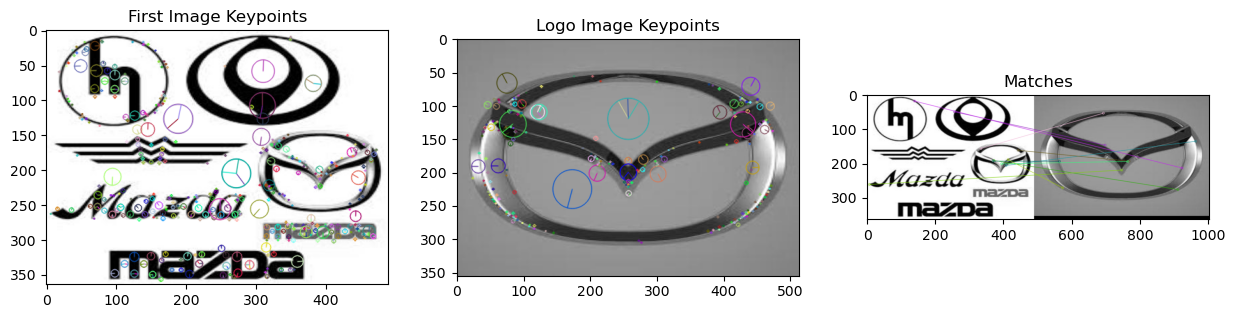

In [66]:
visualize_matches('data/first/37.jpg', 'data/logo/45.jpg')

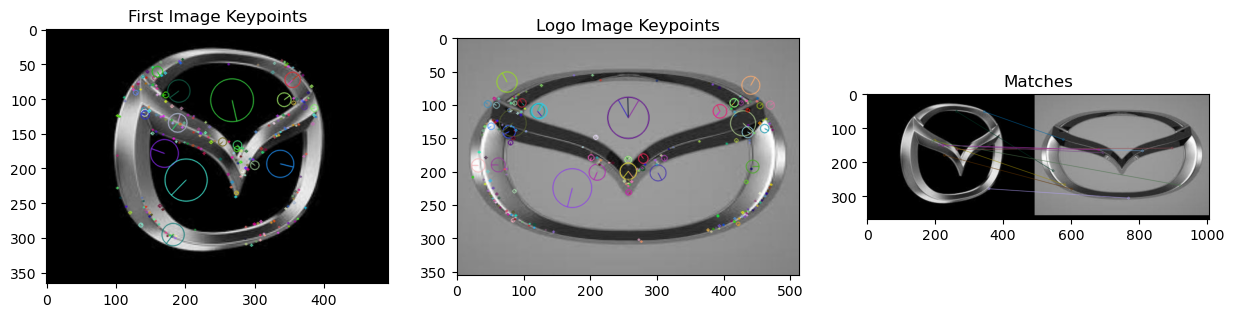

In [69]:
visualize_matches('data/first/46.jpg', 'data/logo/45.jpg')

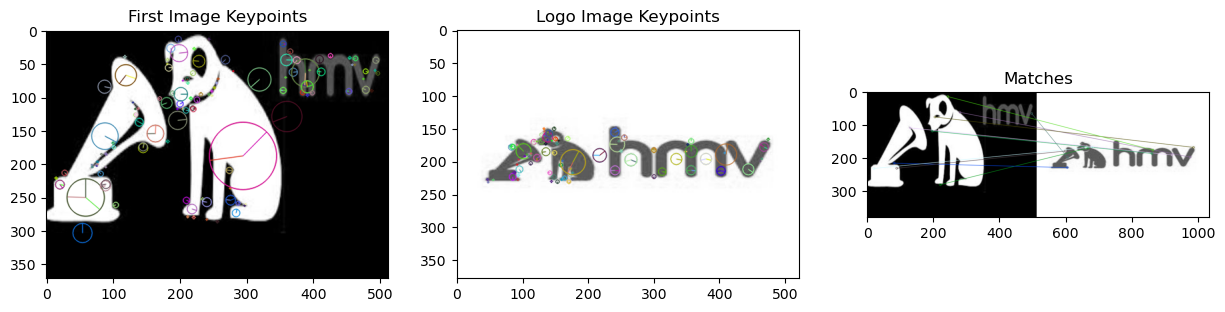

In [70]:
visualize_matches('data/first/3.jpg', 'data/logo/1.jpg')

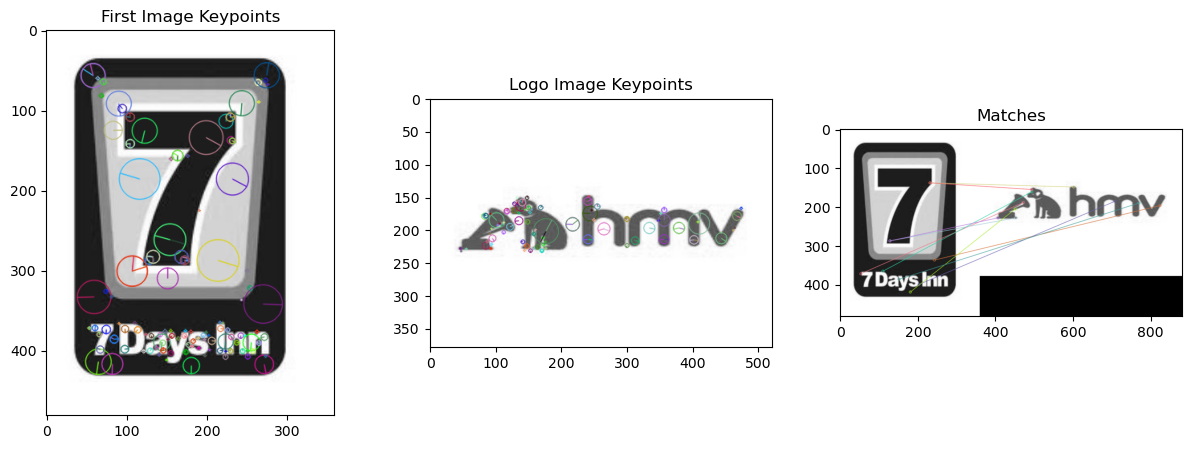

In [73]:
visualize_matches('data/first/1.jpg', 'data/logo/1.jpg')

Как можно заметить, что на данных где логотипы схожи получается довольно хороший результат как на текстовом логотипе, так и на логотипе ввиде изображения. Но на последнем примере можно убедиться, что хоть и логотипы разные, модель все равно находит схожести. Однако, данный подход был реализован без использования RANSAC, который должен решить эту проблему. 

Решила реализовать второй метод с использованием предобученной модели ResNet

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
from scipy.spatial.distance import cosine
import cv2
import matplotlib.pyplot as plt
from collections.abc import Iterable

Загрузим модель и уберем последний слой у нее. 

In [3]:
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1]) 
resnet.eval()

/Users/katiegalaeva/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/katiegalaeva/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Преобразуем все данные в формат, который принимает модель

In [4]:

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

Напишем функцию для извлечения фичей

In [5]:

def extract_resnet_features(image_path):
    image = Image.open(image_path).convert("RGB") 
    image = transform(image).unsqueeze(0)  
    with torch.no_grad():
        features = resnet(image)  
    return features.squeeze().cpu().numpy().flatten()  

Напишем функцию для определения схожести двух эмбедингов с подобранным трешхолдом. 

In [10]:
def compare_images_resnet(img1_path, img2_path, threshold=0.6):
    vec1 = extract_resnet_features(img1_path)
    vec2 = extract_resnet_features(img2_path)
    similarity = 1 - cosine(vec1, vec2)  
    if similarity > threshold:
        print(f"Логотипы совпадают с cosine similarity: {similarity:.4f}")
    else:
        print(f"Логотипы не совпадают с cosine similarity: {similarity:.4f}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(img1_path))
    axes[0].set_title("First Image")
    axes[0].axis("off")

    axes[1].imshow(Image.open(img2_path))
    axes[1].set_title("Logo Image")
    axes[1].axis("off")
    fig.suptitle("Matches", fontsize=14, fontweight="bold")
    plt.show()

Логотипы совпадают с cosine similarity: 0.6152


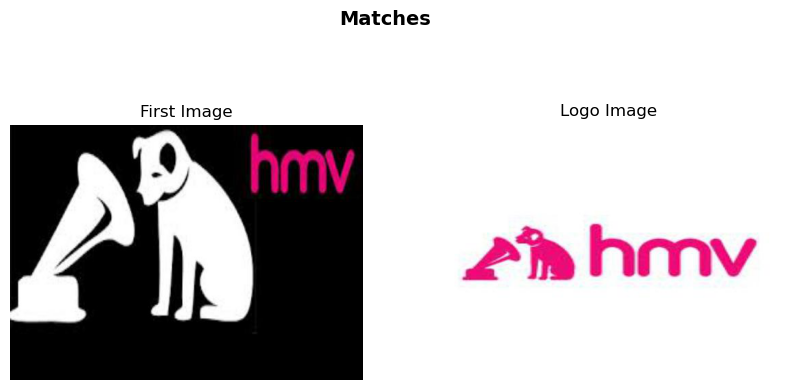

In [11]:
compare_images_resnet("data/first/3.jpg", "data/logo/1.jpg")

Логотипы не совпадают с cosine similarity: 0.5503


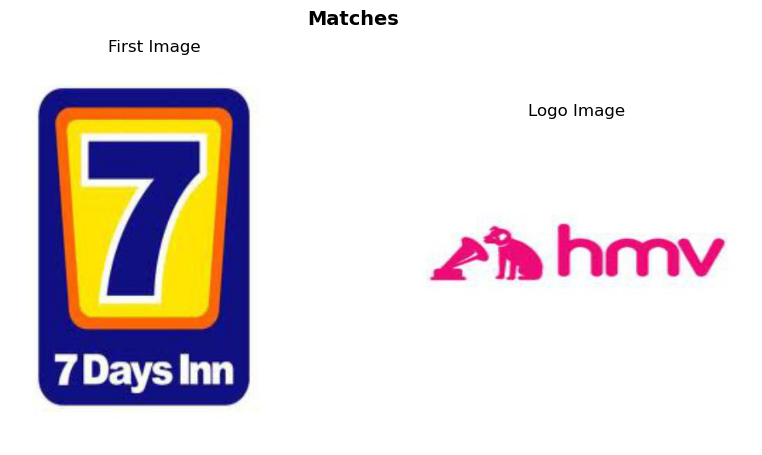

In [12]:
compare_images_resnet('data/first/1.jpg', 'data/logo/1.jpg')

Логотипы совпадают с cosine similarity: 0.6497


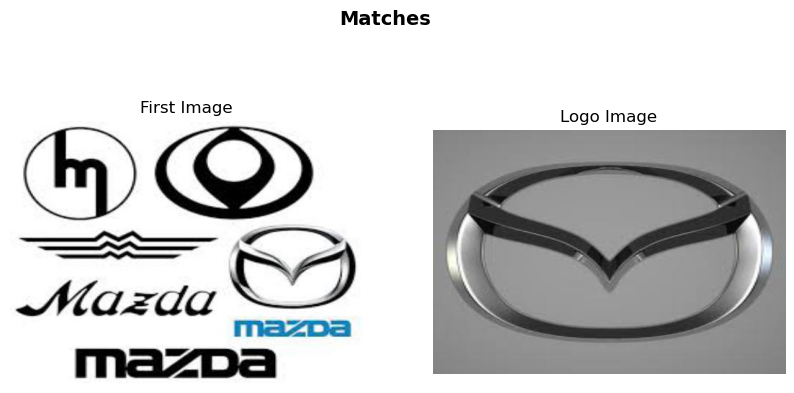

In [13]:
compare_images_resnet('data/first/37.jpg', 'data/logo/45.jpg')

Как можно заметить такой подход показывается лучшие результаты. Особенно стоит обратить внимание, что теперь на абсолютно двух противоположных логотипах не происходит мэтча.